# Baseline SAR Autoencoder Training

Phase 2, Plan 04: Train the baseline autoencoder model.

**Targets:**
- Validation PSNR > 25 dB
- 16x compression with latent_channels=16
- Save best checkpoint with preprocessing_params

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: d:\Projects\CNNAutoencoderProject


In [2]:
import torch
import torch.nn as nn

# Project imports
from src.data.datamodule import SARDataModule
from src.models.autoencoder import SARAutoencoder
from src.losses.combined import CombinedLoss
from src.training.trainer import Trainer

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3070
VRAM: 8.0 GB


## 2. Configuration

Adjust these parameters as needed.

In [3]:
# ============================================================
# CONFIGURATION - Modify these as needed
# ============================================================

# Data settings
DATA_PATH = "D:/Projects/CNNAutoencoderProject/data/patches/metadata.npy"
BATCH_SIZE = 32       # 8 for RTX 3070 8GB VRAM (reduce to 4 if OOM)
NUM_WORKERS = 4       # Increased from 0 for faster data loading (try 2 if issues)
VAL_FRACTION = 0.1    # 10% validation split
TRAIN_SUBSET = 0.20   # Use 20% of training data for faster iteration

# Model settings
LATENT_CHANNELS = 16  # 16 = 16x compression
BASE_CHANNELS = 64    # Base channel count

# Loss settings
MSE_WEIGHT = 0.5
SSIM_WEIGHT = 0.5

# Training settings
EPOCHS = 50
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 10
LR_PATIENCE = 10
LR_FACTOR = 0.5
MAX_GRAD_NORM = 1.0

# Output settings
RUN_NAME = f"baseline_c{LATENT_CHANNELS}_fast"

# Calculate compression ratio
compression_ratio = (256 * 256) / (16 * 16 * LATENT_CHANNELS)
print(f"Compression ratio: {compression_ratio:.0f}x")
print(f"Training subset: {TRAIN_SUBSET*100:.0f}% of data")
print(f"Batch size: {BATCH_SIZE}")
print(f"Num workers: {NUM_WORKERS}")

Compression ratio: 16x
Training subset: 20% of data
Batch size: 32
Num workers: 4


## 3. Load Data

In [4]:
print("Loading data...")
dm = SARDataModule(
    patches_path=DATA_PATH,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    val_fraction=VAL_FRACTION,
)

# Apply subset to BOTH train and val for faster iteration
if TRAIN_SUBSET < 1.0:
    import random
    
    # Subset training data
    full_train_size = len(dm.train_dataset)
    train_subset_size = int(full_train_size * TRAIN_SUBSET)
    train_indices = random.sample(range(full_train_size), train_subset_size)
    dm.train_dataset = torch.utils.data.Subset(dm.train_dataset, train_indices)
    
    # Subset validation data (same proportion)
    full_val_size = len(dm.val_dataset)
    val_subset_size = int(full_val_size * TRAIN_SUBSET)
    val_indices = random.sample(range(full_val_size), val_subset_size)
    dm.val_dataset = torch.utils.data.Subset(dm.val_dataset, val_indices)
    
    print(f"Using {TRAIN_SUBSET*100:.0f}% subset:")
    print(f"  Train: {train_subset_size:,} of {full_train_size:,}")
    print(f"  Val: {val_subset_size:,} of {full_val_size:,}")

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

print(f"\nDataset loaded:")
print(f"  Train patches: {len(dm.train_dataset):,}")
print(f"  Val patches: {len(dm.val_dataset):,}")
print(f"  Train batches: {len(train_loader):,}")
print(f"  Val batches: {len(val_loader):,}")
print(f"  Preprocessing params: {dm.preprocessing_params}")

# Estimate epoch time
est_batches = len(train_loader) + len(val_loader)
est_time_min = est_batches / 2.5 / 60  # ~2.5 it/s with batch_size=32
print(f"\n  Estimated time per epoch: ~{est_time_min:.0f} minutes")

Loading data...
Loading metadata from D:\Projects\CNNAutoencoderProject\data\patches\metadata.npy
Total patches: 696277
Train: 626650, Val: 69627
Using 20% subset:
  Train: 125,330 of 626,650
  Val: 13,925 of 69,627

Dataset loaded:
  Train patches: 125,330
  Val patches: 13,925
  Train batches: 3,916
  Val batches: 436
  Preprocessing params: {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}

  Estimated time per epoch: ~29 minutes


In [5]:
# Verify a sample batch
sample_batch = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch.shape}")
print(f"Sample batch dtype: {sample_batch.dtype}")
print(f"Sample batch range: [{sample_batch.min():.4f}, {sample_batch.max():.4f}]")

Sample batch shape: torch.Size([32, 1, 256, 256])
Sample batch dtype: torch.float32
Sample batch range: [0.0000, 1.0000]


## 4. Create Model

In [6]:
print("Creating model...")
model = SARAutoencoder(
    latent_channels=LATENT_CHANNELS,
    base_channels=BASE_CHANNELS,
)

params = model.count_parameters()
print(f"\nModel created:")
print(f"  Total parameters: {params['total']:,}")
print(f"  Encoder params: {params['encoder']:,}")
print(f"  Decoder params: {params['decoder']:,}")
print(f"  Compression ratio: {model.get_compression_ratio():.1f}x")
print(f"  Latent size: {model.get_latent_size()}")

Creating model...

Model created:
  Total parameters: 2,257,809
  Encoder params: 1,128,912
  Decoder params: 1,128,897
  Compression ratio: 16.0x
  Latent size: (16, 16, 16)


In [7]:
# Test forward pass
print("Testing forward pass...")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_test = model.to(device)
x_test = sample_batch[:2].to(device)

with torch.no_grad():
    x_hat, z = model_test(x_test)

print(f"  Input: {x_test.shape}")
print(f"  Latent: {z.shape}")
print(f"  Output: {x_hat.shape}")
print(f"  Output range: [{x_hat.min():.4f}, {x_hat.max():.4f}]")

# Clean up test
del model_test, x_test, x_hat, z
torch.cuda.empty_cache()

Testing forward pass...
  Input: torch.Size([2, 1, 256, 256])
  Latent: torch.Size([2, 16, 16, 16])
  Output: torch.Size([2, 1, 256, 256])
  Output range: [0.0660, 0.9405]


## 5. Create Loss Function

In [8]:
loss_fn = CombinedLoss(
    mse_weight=MSE_WEIGHT,
    ssim_weight=SSIM_WEIGHT,
)

print(f"Loss function: CombinedLoss")
print(f"  MSE weight: {MSE_WEIGHT}")
print(f"  SSIM weight: {SSIM_WEIGHT}")

Loss function: CombinedLoss
  MSE weight: 0.5
  SSIM weight: 0.5


## 6. Initialize Trainer

In [9]:
# Training configuration
config = {
    'learning_rate': LEARNING_RATE,
    'lr_patience': LR_PATIENCE,
    'lr_factor': LR_FACTOR,
    'max_grad_norm': MAX_GRAD_NORM,
    'run_name': RUN_NAME,
    'preprocessing_params': dm.preprocessing_params,
    # Store hyperparams for reproducibility
    'latent_channels': LATENT_CHANNELS,
    'base_channels': BASE_CHANNELS,
    'mse_weight': MSE_WEIGHT,
    'ssim_weight': SSIM_WEIGHT,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
}

print("Initializing trainer...")
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    config=config,
)

print(f"\nTrainer ready:")
print(f"  Log dir: {trainer.log_dir}")
print(f"  Checkpoint dir: {trainer.checkpoint_dir}")
print(f"  Device: {trainer.device}")

d:\Projects\CNNAutoencoderProject\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2026-01-22 19:53:40,650 - Log directory: runs\baseline_c16_fast
2026-01-22 19:53:40,651 - Checkpoint directory: checkpoints\baseline_c16_fast


Initializing trainer...
Using device: cuda

Trainer ready:
  Log dir: runs\baseline_c16_fast
  Checkpoint dir: checkpoints\baseline_c16_fast
  Device: cuda


## 7. Train Model

**Expected duration:** ~2-4 hours for 50 epochs on RTX 3070

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=runs
```

In [10]:
print("=" * 60)
print("Starting Training")
print("=" * 60)
print(f"Epochs: {EPOCHS}")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"\nTensorBoard: tensorboard --logdir={trainer.log_dir.parent}")
print(f"Checkpoints: {trainer.checkpoint_dir}")
print("=" * 60)

trainer.load_checkpoint('checkpoints/baseline_c16_fast/latest.pth')

history = trainer.train(
    epochs=EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
)

d:\Projects\CNNAutoencoderProject\src\training\trainer.py:264: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=self.device)
2026-01-

Starting Training
Epochs: 50
Early stopping patience: 10
Learning rate: 0.0001

TensorBoard: tensorboard --logdir=runs
Checkpoints: checkpoints\baseline_c16_fast


Epoch 22 [Val]: 100%|██████████| 436/436 [00:37<00:00, 11.56it/s, loss=0.1948, psnr=20.32, ssim=0.6198]
2026-01-22 20:00:11,179 - New best model saved (val_loss: 0.1900)
2026-01-22 20:00:11,179 - Epoch 22/50 | Train: loss=0.1881, psnr=20.00, ssim=0.6337 | Val: loss=0.1900, psnr=20.19, ssim=0.6295 | LR: 1.00e-04 | GPU: 0.03GB
Epoch 23 [Val]: 100%|██████████| 436/436 [00:15<00:00, 28.15it/s, loss=0.1952, psnr=20.35, ssim=0.6188]
2026-01-22 20:06:16,858 - Epoch 23/50 | Train: loss=0.1877, psnr=20.01, ssim=0.6346 | Val: loss=0.1904, psnr=20.23, ssim=0.6286 | LR: 1.00e-04 | GPU: 0.03GB
Epoch 24 [Val]: 100%|██████████| 436/436 [00:15<00:00, 28.09it/s, loss=0.1931, psnr=20.39, ssim=0.6230]
2026-01-22 20:12:26,463 - New best model saved (val_loss: 0.1885)
2026-01-22 20:12:26,464 - Epoch 24/50 | Train: loss=0.1872, psnr=20.02, ssim=0.6355 | Val: loss=0.1885, psnr=20.26, ssim=0.6325 | LR: 1.00e-04 | GPU: 0.03GB
Epoch 25 [Val]: 100%|██████████| 436/436 [00:15<00:00, 28.26it/s, loss=0.1935, psnr=2

## 8. Training Summary

In [ ]:
print("=" * 60)
print("Training Complete")
print("=" * 60)

if history:
    final = history[-1]
    print(f"Final epoch: {final['epoch'] + 1}")
    print(f"Best val loss: {trainer.best_val_loss:.4f}")
    print(f"Final val PSNR: {final['val_psnr']:.2f} dB")
    print(f"Final val SSIM: {final['val_ssim']:.4f}")
    
    # Check success criterion
    if final['val_psnr'] >= 25:
        print("\n" + "=" * 60)
        print("[SUCCESS] PSNR > 25 dB achieved!")
        print("=" * 60)
    else:
        print(f"\n[WARNING] PSNR {final['val_psnr']:.2f} < 25 dB target")

print(f"\nBest checkpoint: {trainer.checkpoint_dir / 'best.pth'}")

Training Complete
Final epoch: 50
Best val loss: 0.1813
Final val PSNR: 20.29 dB
Final val SSIM: 0.6424

[WARNING] PSNR 20.29 < 25 dB target

Best checkpoint: checkpoints\baseline_c16_fast\best.pth


: 

## 9. Visualize Training History

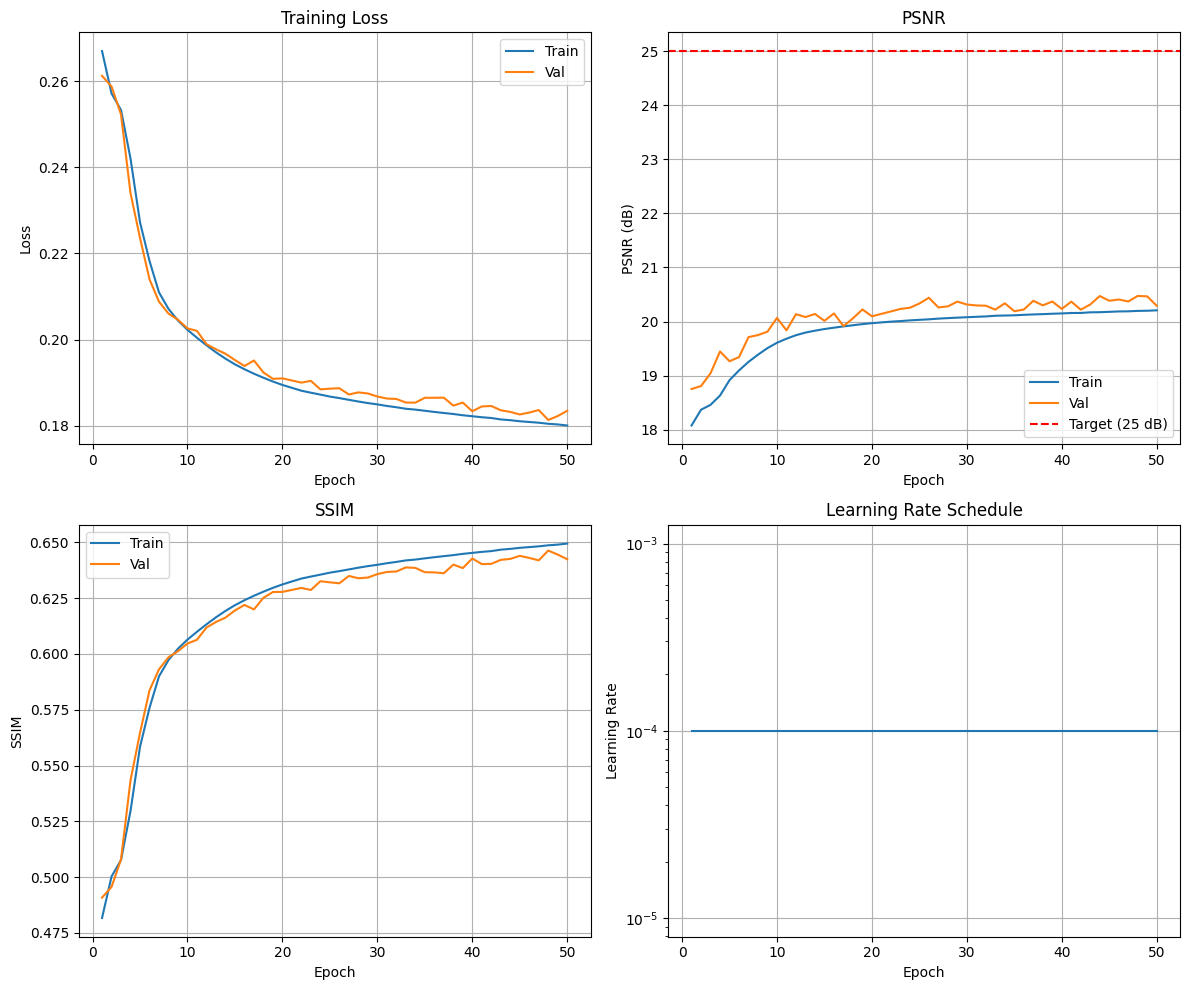


Saved training curves to: runs\baseline_c16_fast\training_curves.png


In [12]:
import matplotlib.pyplot as plt

if history:
    epochs = [h['epoch'] + 1 for h in history]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Loss
    ax = axes[0, 0]
    ax.plot(epochs, [h['train_loss'] for h in history], label='Train')
    ax.plot(epochs, [h['val_loss'] for h in history], label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    ax.legend()
    ax.grid(True)
    
    # PSNR
    ax = axes[0, 1]
    ax.plot(epochs, [h['train_psnr'] for h in history], label='Train')
    ax.plot(epochs, [h['val_psnr'] for h in history], label='Val')
    ax.axhline(y=25, color='r', linestyle='--', label='Target (25 dB)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('PSNR (dB)')
    ax.set_title('PSNR')
    ax.legend()
    ax.grid(True)
    
    # SSIM
    ax = axes[1, 0]
    ax.plot(epochs, [h['train_ssim'] for h in history], label='Train')
    ax.plot(epochs, [h['val_ssim'] for h in history], label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('SSIM')
    ax.set_title('SSIM')
    ax.legend()
    ax.grid(True)
    
    # Learning Rate
    ax = axes[1, 1]
    ax.plot(epochs, [h['learning_rate'] for h in history])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title('Learning Rate Schedule')
    ax.set_yscale('log')
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(trainer.log_dir / 'training_curves.png', dpi=150)
    plt.show()
    
    print(f"\nSaved training curves to: {trainer.log_dir / 'training_curves.png'}")

## 10. Verify Checkpoint

In [13]:
# Verify checkpoint can be loaded
checkpoint_path = trainer.checkpoint_dir / 'best.pth'

if checkpoint_path.exists():
    ckpt = torch.load(checkpoint_path, map_location='cpu')
    print("Checkpoint contents:")
    print(f"  Keys: {list(ckpt.keys())}")
    print(f"  Epoch: {ckpt['epoch']}")
    print(f"  Best val loss: {ckpt['best_val_loss']:.4f}")
    print(f"  Preprocessing params: {ckpt.get('preprocessing_params', 'MISSING')}")
    
    # Test loading into fresh model
    print("\nLoading weights into fresh model...")
    test_model = SARAutoencoder(latent_channels=LATENT_CHANNELS)
    test_model.load_state_dict(ckpt['model_state_dict'])
    test_model.eval()
    
    # Test inference
    x = torch.rand(1, 1, 256, 256)
    with torch.no_grad():
        x_hat, z = test_model(x)
    
    print(f"  Inference test: {x.shape} -> {z.shape} -> {x_hat.shape}")
    print("\nCheckpoint verification: PASS")
else:
    print(f"Checkpoint not found at: {checkpoint_path}")

Checkpoint contents:
  Keys: ['epoch', 'global_step', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'best_val_loss', 'epochs_without_improvement', 'config', 'preprocessing_params', 'history']
  Epoch: 47
  Best val loss: 0.1813
  Preprocessing params: {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}

Loading weights into fresh model...


C:\Users\amdc1\AppData\Local\Temp\ipykernel_25656\2270505771.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location='cpu')


  Inference test: torch.Size([1, 1, 256, 256]) -> torch.Size([1, 16, 16, 16]) -> torch.Size([1, 1, 256, 256])

Checkpoint verification: PASS


## 11. Sample Reconstructions

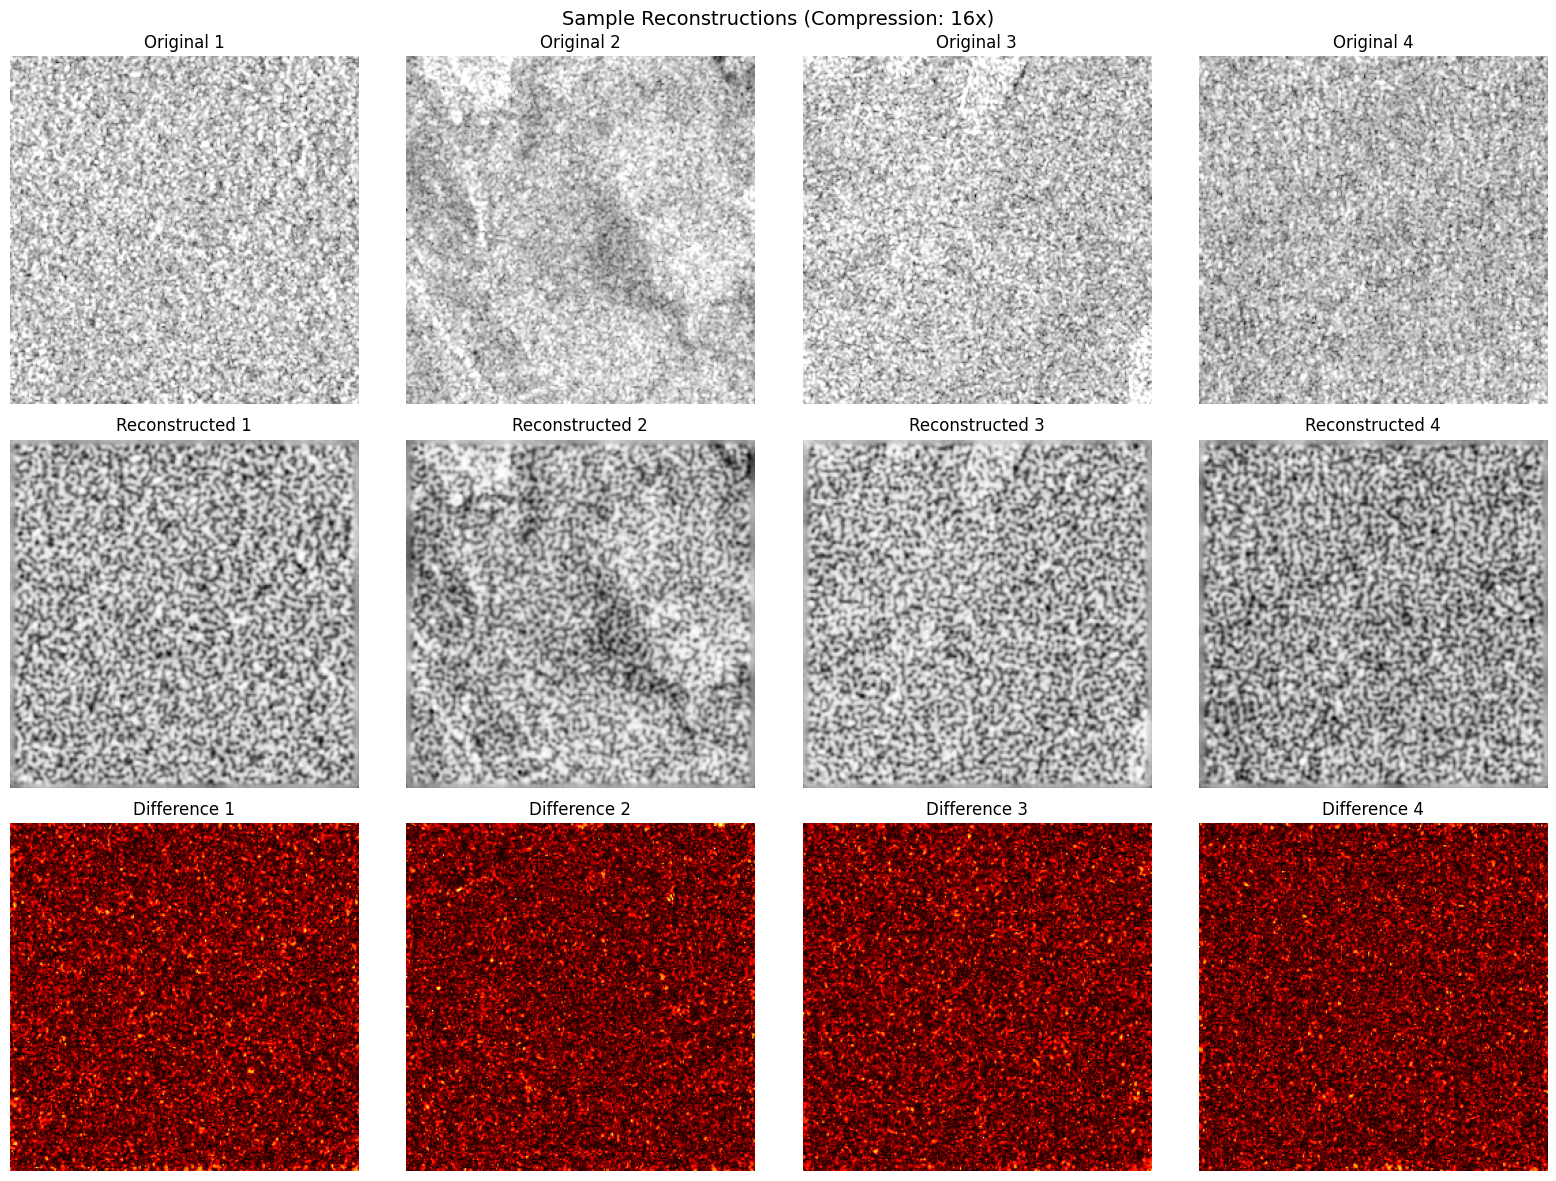

In [14]:
# Visualize some sample reconstructions from validation set
import matplotlib.pyplot as plt

model.eval()
device = next(model.parameters()).device

# Get a batch from validation
val_batch = next(iter(val_loader))[:4].to(device)

with torch.no_grad():
    reconstructed, latent = model(val_batch)

# Move to CPU for plotting
originals = val_batch.cpu().numpy()
reconstructions = reconstructed.cpu().numpy()

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(4):
    # Original
    axes[0, i].imshow(originals[i, 0], cmap='gray')
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')
    
    # Reconstruction
    axes[1, i].imshow(reconstructions[i, 0], cmap='gray')
    axes[1, i].set_title(f'Reconstructed {i+1}')
    axes[1, i].axis('off')
    
    # Difference
    diff = abs(originals[i, 0] - reconstructions[i, 0])
    axes[2, i].imshow(diff, cmap='hot', vmin=0, vmax=0.5)
    axes[2, i].set_title(f'Difference {i+1}')
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
axes[2, 0].set_ylabel('Difference', fontsize=12)

plt.suptitle(f'Sample Reconstructions (Compression: {model.get_compression_ratio():.0f}x)', fontsize=14)
plt.tight_layout()
plt.savefig(trainer.log_dir / 'sample_reconstructions.png', dpi=150)
plt.show()

---

## Done!

**Next steps:**
1. View TensorBoard: `tensorboard --logdir=runs`
2. Check the best checkpoint at the path shown above
3. Proceed to Phase 3: SAR Evaluation metrics